# systematics with the Asimov dataset

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline

/home/naodell/work/wbr/analysis


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'data/templates/bjet_binned_test/'
selections = [
              'emu', 
              'mumu',  'mutau', 'mu4j',
              #'ee',  'etau', 'e4j'
             ]
n_selection = len(selections)
targets    = dict(
                  mumu  = 'lepton2_pt', 
                  ee    = 'lepton2_pt', 
                  emu   = 'trailing_lepton_pt', 
                  mutau = 'lepton2_pt', 
                  etau  = 'lepton2_pt', 
                  mu4j  = 'lepton1_pt',
                  e4j   = 'lepton1_pt'
                 )
plot_labels = dict(
                   mumu  = [r'$\sf p_{T, \mu}$', r'$\mu\mu$'],
                   ee    = [r'$\sf p_{T, e}$', r'$ee$'],
                   emu   = [r'$\sf p_{T, \ell}$', r'$e\mu$'],
                   mutau = [r'$\sf p_{T, \tau}$', r'$\mu\tau$'],
                   etau  = [r'$\sf p_{T, \tau}$', r'$e\tau$'],
                   mu4j  = [r'$\sf p_{T, \mu}$', r'$\mu$ + jets'],
                   e4j   = [r'$\sf p_{T, e}$', r'$e$ + jets']
                  )
#p_labels = [r'$\beta_{e}$', r'$\beta_{\mu}$', r'$\beta_{\tau}$', r'$\beta_{h}$',
#            r'$\sf L_{int}$', 
#            r'$\sigma_{t\bar{t}}$',  r'$\sigma_{z}$',  r'$\sigma_{w}$', r'$\sf k_{fakes}$', 
#            r'$\sf \epsilon_{e}$', r'$\sf \epsilon_{\mu}$', r'$\sf \epsilon_{\tau}$']

p_labels = ['B_e', 'B_mu', 'B_tau', 'B_h', 
            'L', 'sigma_tt', 'sigma_z', 'sigma_w', 'k_fake', 
            'eff_e', 'eff_mu', 'eff_tau', 
            'pileup', 'escale_e', 'escale_mu', 'escale_tau', 
            'jes', 'jer', 'btag', 'mistag',
            'fsr', 'isr', 'tune', 'hdamp', 'qcd', 'pdf'
           ]

# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h) and tau branching fraction (b_e, b_mu, b_h)
br_tau    = [0.1783, 0.1741, 0.6476]
beta_init = [0.108, 0.108, 0.108, 1 - 3*0.108] 
var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]

# initialize fit data
fit_data = fh.FitData(input_dir, selections, targets, bins=[1, 2])

In [3]:
# generate Asimov dataset
toy_data = dict()
for b in fit_data._bins:
    toy_data[b] = dict()
    for selection in selections:
        # signal component
        templates = fit_data.get_selection_data(selection)
        signal_template = templates[b]['signal']
        signal = fh.signal_mixture_model(beta_init, br_tau, signal_template, sample=False)[0]

        toy_data[b][selection] = signal
        # background component
        for bg in ['zjets', 'wjets', 'fakes']:
            if bg == 'fakes' and selection not in ['mu4j', 'mutau']:
                continue

            bg_template = templates[b][bg][0]
            toy_data[b][selection] += bg_template

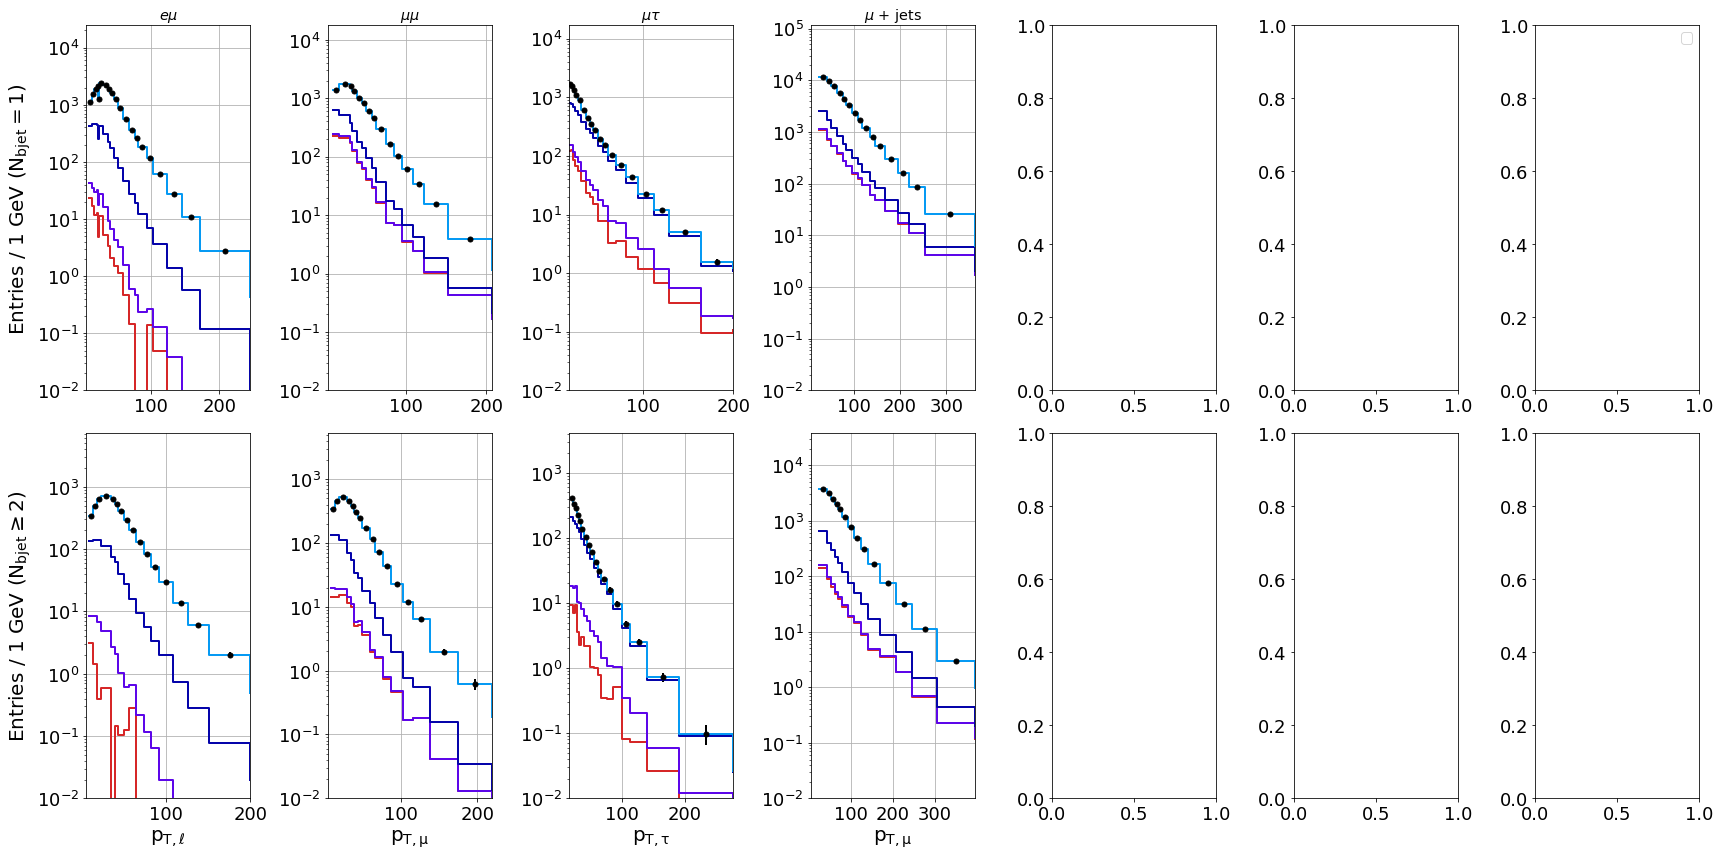

In [4]:
# visualize toy data
fig, axes = plt.subplots(2, 7, figsize=(24, 12), facecolor='white')
for i, selection in enumerate(selections):
    s_data = fit_data.get_selection_data(selection)
#
    for j, b in enumerate(fit_data._bins):
        bins = s_data[b]['bins']
        dx = (bins[1:] - bins[:-1])
        dx = np.append(dx, dx[-1]) 
        x = bins + dx/2            

        ax = axes[j][i]
        data = toy_data[b][selection]
        ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)
        
        # validation plot
        br = 0.108
        signal = s_data[b]['signal']
        bg = s_data[b]['wjets'][0] + s_data[b]['zjets'][0]
        if selection in ['mu4j', 'mutau']:
            bg += s_data[b]['fakes'][0]
            
        h_notau   = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal, mask=fit_data._decay_map['sig_twotau']) + bg
        h_onetau  = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal, mask=fit_data._decay_map['sig_onetau']) + h_notau
        h_nominal = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal) + bg
        
        ax.plot(bins, bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2.)
        ax.plot(bins, h_notau[0]/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2.)
        ax.plot(bins, h_onetau[0]/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2.)
        ax.plot(bins, h_nominal[0]/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2.)
        
        xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
        ax.set_yscale('log')
        if j == 0:
            ax.set_title(plot_labels[selection][1])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} = 1$)')
        elif j == 1:
            ax.set_xlabel(plot_labels[selection][0])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} \geq 2$)')
        ax.grid()
    
    axes[0][-1].legend(['bg', r'2 $\tau$', r'1 $\tau$', r'0 $\tau$', 'toy data'], fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example.pdf')
plt.show()

In [5]:
# nominal case
cost_type = 'poisson'
p_init = list(fit_data.get_params_init()) + 22*[1., ] # niceify this: nuisance parameters are initialized to 1
p_init = np.array(p_init)
fobj = partial(fit_data.objective, data=toy_data, cost_type=cost_type)
stderr, corr = fh.calculate_covariance(fobj, p_init)

In [6]:
pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', len(p_labels))
pd.set_option('display.max_rows', len(p_labels))

#print(result.x)
#print(cov[0])
pct_err = pd.DataFrame(100*stderr/p_init, index=p_labels, columns=['stderr'])
df_corr = pd.DataFrame(corr, columns=p_labels, index=p_labels)
pct_err

,stderr
B_e,1.336
B_mu,0.729
B_tau,2.631
B_h,0.462
L,1.981
sigma_tt,2.686
sigma_z,8.897
sigma_w,12.122
k_fake,12.096
eff_e,0.931


<bound method Artist.set of <matplotlib.axes._subplots.AxesSubplot object at 0x7f17cf709208>>

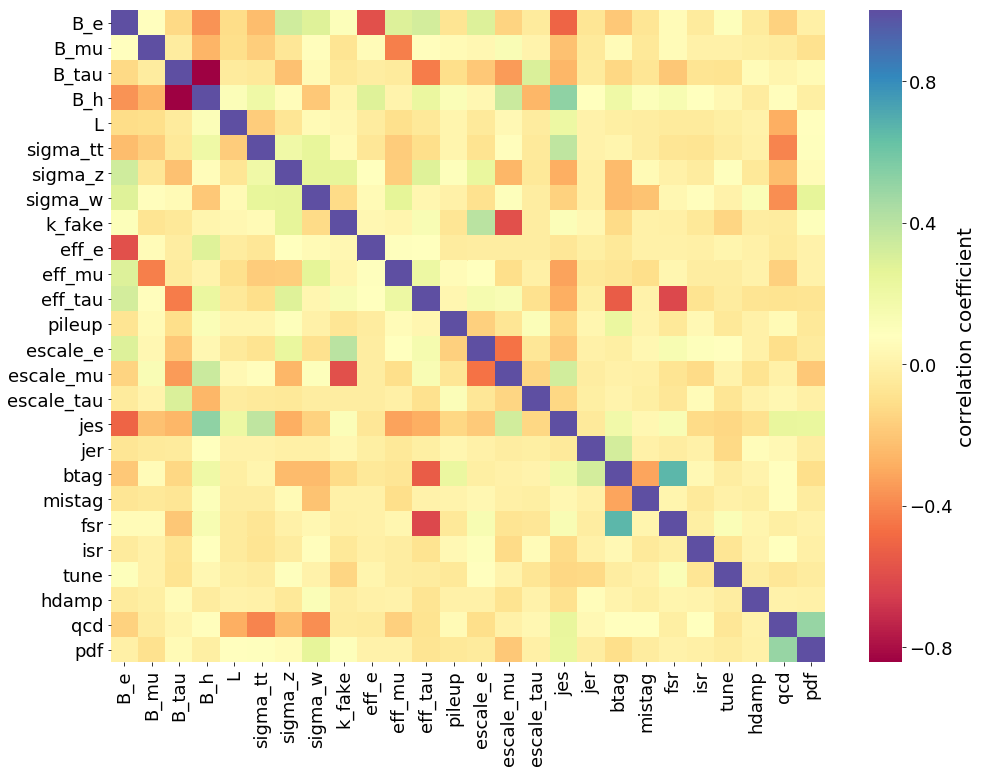

In [7]:
df_corr.to_latex('data/cov_table_full.tex')
df_corr.to_csv('data/cov_table_full.csv')

import seaborn as sns
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16, 12))
sns.heatmap(df_corr, cmap='Spectral', ax=ax, cbar_kws={'label': r'correlation coefficient'})
ax.set

In [8]:
# n-1 uncertainties
from tqdm import tqdm_notebook, trange

def reduced_objective(p, i, j=None):
    if j == None or j < i:
        j = i
        
    p = np.concatenate([p[:i], (j - i + 1)*[1,], p[j:]])
    return fit_data.objective(p, data=toy_data, cost_type=cost_type)

# stat only
fobj = partial(reduced_objective, i=4, j=len(p_init))
stderr_stat = np.concatenate([fh.calculate_covariance(fobj, p_init[:4])[0], p_init[4:].size*[0.,]])

errs = [stderr_stat]
p_init = p_init
for i in tqdm_notebook(range(4, len(p_init))):
    fobj = partial(reduced_objective, i=i)
    stderr, cov = fh.calculate_covariance(fobj, p_init[:-1])
    
    stderr = np.concatenate([stderr[:i], [0], stderr[i:]])
    errs.append(stderr)
    
# full systematics
fobj = partial(fit_data.objective, data=toy_data, cost_type=cost_type)
stderr_nominal = fh.calculate_covariance(fobj, p_init)[0]
errs.append(stderr_nominal)

HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

In [9]:
errs = pd.DataFrame(errs, columns=p_labels, index=['stat only'] + p_labels[4:] + ['full'])
errs.divide(p_init/100, axis=1)

,B_e,B_mu,B_tau,B_h,L,sigma_tt,sigma_z,sigma_w,k_fake,eff_e,eff_mu,eff_tau,pileup,escale_e,escale_mu,escale_tau,jes,jer,btag,mistag,fsr,isr,tune,hdamp,qcd,pdf
stat only,0.320,0.111,0.812,0.116,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
L,1.328,0.726,2.629,0.459,0.000,2.645,8.875,12.108,12.090,0.930,0.813,1.904,59.349,19.232,13.524,17.588,38.902,88.519,8.189,99.638,8.688,16.355,13.033,11.512,23.295,74.661
sigma_tt,1.300,0.719,2.627,0.453,1.951,0.000,8.738,11.745,12.084,0.929,0.804,1.895,59.347,19.187,13.502,17.579,36.786,88.518,8.188,99.644,8.674,16.325,13.028,11.511,22.217,74.576
sigma_z,1.260,0.728,2.565,0.461,1.976,2.638,0.000,11.714,11.686,0.928,0.805,1.828,59.066,18.736,13.082,17.569,38.211,88.515,7.946,99.572,8.696,16.361,12.981,11.494,23.615,74.763
sigma_w,1.282,0.728,2.628,0.454,1.979,2.602,8.597,0.000,12.014,0.930,0.789,1.906,59.356,19.172,13.474,17.591,39.347,88.513,7.953,97.426,8.692,16.331,13.035,11.429,22.507,72.350
k_fake,1.328,0.727,2.627,0.462,1.980,2.683,8.595,12.040,0.000,0.930,0.817,1.890,59.205,17.661,10.976,17.592,39.586,88.472,8.128,99.675,8.695,16.345,12.901,11.507,24.301,74.495
eff_e,1.080,0.728,2.630,0.443,1.980,2.681,8.868,12.109,12.089,0.000,0.814,1.900,59.326,19.247,13.529,17.591,39.753,88.506,8.178,99.674,8.696,16.368,13.032,11.512,24.290,74.862
eff_mu,1.277,0.661,2.628,0.462,1.971,2.642,8.770,11.709,12.094,0.927,0.000,1.862,59.270,19.192,13.460,17.595,37.727,88.383,8.170,99.101,8.693,16.364,13.029,11.512,23.999,74.863
eff_tau,1.264,0.728,2.373,0.450,1.979,2.670,8.533,12.119,11.992,0.928,0.798,0.000,59.343,19.026,13.409,17.524,38.153,88.504,6.892,99.676,6.829,16.312,13.028,11.481,24.235,74.633
pileup,1.332,0.729,2.617,0.459,1.981,2.685,8.854,12.122,12.065,0.930,0.816,1.906,0.000,18.992,13.503,17.482,39.460,88.498,7.972,99.673,8.683,16.356,13.016,11.512,24.287,74.743


### Estimating individual contributions

If we make the assumption that the uncertainties sum in quadrature (which they should really given all of the correlations), we can write the total uncertainty as,

$$
\sigma_{total}^{2} = \sigma_{stat}^{2} + \sum_{i}\sigma_{i,syst}^{2}
$$

From this we can write evaluate the contribution from a single systematic source as,

$$
\sigma_{i,syst}^{2} = \sigma_{total}^{2} - \sigma_{stat}^{2} - \sum_{j\neq i}\sigma_{j,syst}^{2}
$$


In [10]:
beta_vars = errs.iloc[:,:4]**2
var_stat = beta_vars.iloc[0]
var_nom  = beta_vars.iloc[-1]

for i in trange(1, beta_vars.shape[0] - 1):
    beta_vars.iloc[i] = var_nom - beta_vars.iloc[i]
    
beta_errs = np.sqrt(beta_vars)
100*beta_errs.divide(p_init[:4], axis=1)

100%|██████████| 22/22 [00:00<00:00, 1167.96it/s]


,B_e,B_mu,B_tau,B_h
stat only,0.320,0.111,0.812,0.116
L,0.147,0.074,0.104,0.052
sigma_tt,0.309,0.122,0.141,0.091
sigma_z,0.443,0.043,0.585,0.030
sigma_w,0.376,0.050,0.122,0.087
k_fake,0.142,0.057,0.140,0.009
eff_e,0.786,0.041,0.068,0.130
eff_mu,0.391,0.308,0.112,0.005
eff_tau,0.431,0.051,1.135,0.104
pileup,0.105,0.034,0.269,0.054
